# Imports

In [13]:
import os
import copy
import numpy as np
from PIL import Image
import matplotlib.cm as mpl_color_map
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt

import torch
from torch.autograd import Variable
from torchvision import models

## Misc Funcitions
Save files, generate heat map, resize, etc...

In [14]:
def save_class_activation_images(org_img, activation_map, file_name):
    """
        Saves cam activation map and activation map on the original image

    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        file_name (str): File name of the exported image
    """
    if not os.path.exists('results'):
        os.makedirs('results')
    # Grayscale activation map
    heatmap, heatmap_on_image = apply_colormap_on_image(org_img, activation_map, 'hsv')
    plt.imshow(heatmap)
    plt.show()
    # Save colored heatmap
    path_to_file = os.path.join('results', file_name+'_Cam_Heatmap.png')
    save_image(heatmap, path_to_file)
    # Save heatmap on iamge
    path_to_file = os.path.join('results', file_name+'_Cam_On_Image.png')
    save_image(heatmap_on_image, path_to_file)
    plt.imshow(heatmap_on_image)
    plt.show()
    # SAve grayscale heatmap
    path_to_file = os.path.join('results', file_name+'_Cam_Grayscale.png')
    save_image(activation_map, path_to_file)
    plt.imshow(activation_map)
    plt.show()


def apply_colormap_on_image(org_im, activation, colormap_name):
    """
        Apply heatmap on image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        colormap_name (str): Name of the colormap
    """
    # Get colormap
    color_map = mpl_color_map.get_cmap(colormap_name)
    no_trans_heatmap = color_map(activation)
    # Change alpha channel in colormap to make sure original image is displayed
    heatmap = copy.copy(no_trans_heatmap)
    heatmap[:, :, 3] = 0.4
    heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
    no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))

    # Apply heatmap on image
    heatmap_on_image = Image.new("RGBA", org_im.size)
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, org_im.convert('RGBA'))
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, heatmap)
    return no_trans_heatmap, heatmap_on_image


def apply_heatmap(R, sx, sy):
    """
        Heatmap code stolen from https://git.tu-berlin.de/gmontavon/lrp-tutorial

        This is (so far) only used for LRP
    """
    b = 10*((np.abs(R)**3.0).mean()**(1.0/3))
    my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
    my_cmap[:, 0:3] *= 0.85
    my_cmap = ListedColormap(my_cmap)
    plt.figure(figsize=(sx, sy))
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.axis('off')
    heatmap = plt.imshow(R, cmap=my_cmap, vmin=-b, vmax=b, interpolation='nearest')
    return heatmap
    # plt.show()


def format_np_output(np_arr):
    """
        This is a (kind of) bandaid fix to streamline saving procedure.
        It converts all the outputs to the same format which is 3xWxH
        with using sucecssive if clauses.
    Args:
        im_as_arr (Numpy array): Matrix of shape 1xWxH or WxH or 3xWxH
    """
    # Phase/Case 1: The np arr only has 2 dimensions
    # Result: Add a dimension at the beginning
    if len(np_arr.shape) == 2:
        np_arr = np.expand_dims(np_arr, axis=0)
    # Phase/Case 2: Np arr has only 1 channel (assuming first dim is channel)
    # Result: Repeat first channel and convert 1xWxH to 3xWxH
    if np_arr.shape[0] == 1:
        np_arr = np.repeat(np_arr, 3, axis=0)
    # Phase/Case 3: Np arr is of shape 3xWxH
    # Result: Convert it to WxHx3 in order to make it saveable by PIL
    if np_arr.shape[0] == 3:
        np_arr = np_arr.transpose(1, 2, 0)
    # Phase/Case 4: NP arr is normalized between 0-1
    # Result: Multiply with 255 and change type to make it saveable by PIL
    if np.max(np_arr) <= 1:
        np_arr = (np_arr*255).astype(np.uint8)
    return np_arr


def save_image(im, path):
    """
        Saves a numpy matrix or PIL image as an image
    Args:
        im_as_arr (Numpy array): Matrix of shape DxWxH
        path (str): Path to the image
    """
    if isinstance(im, (np.ndarray, np.generic)):
        im = format_np_output(im)
        im = Image.fromarray(im)
    im.save(path)


def preprocess_image(pil_im, resize_im=True):
    """
        Processes image for CNNs

    Args:
        PIL_img (PIL_img): PIL Image or numpy array to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # Mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    # Ensure or transform incoming image to PIL image
    if type(pil_im) != Image.Image:
        try:
            pil_im = Image.fromarray(pil_im)
        except Exception as e:
            print("could not transform PIL_img to a PIL Image object. Please check input.")

    # Resize image
    if resize_im:
        pil_im = pil_im.resize((224, 224), Image.ANTIALIAS)

    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var



def get_example_params(example_index):
    """
        Gets used variables for almost all visualizations, like the image, model etc.

    Args:
        example_index (int): Image id to use from examples

    returns:
        original_image (numpy arr): Original image read from the file
        prep_img (numpy_arr): Processed image
        target_class (int): Target class for the image
        file_name_to_export (string): File name to export the visualizations
        pretrained_model(Pytorch model): Model to use for the operations
    """
    # Pick one of the examples
    example_list = (('input_images/snake.png', 56),
                    ('input_images/cat_dog.png', 243),
                    ('input_images/spider.png', 72))
    img_path = example_list[example_index][0]
    target_class = example_list[example_index][1]
    file_name_to_export = img_path[img_path.rfind('/')+1:img_path.rfind('.')]
    # Read image
    original_image = Image.open(img_path).convert('RGB')
    # Process image
    prep_img = preprocess_image(original_image)
    # Define model
    pretrained_model = models.alexnet(pretrained=True)
    return (original_image,
            prep_img,
            target_class,
            file_name_to_export,
            pretrained_model)

## Grad Cam
Generating heatmap, heatmap on image and

In [15]:
class CamExtractor():
    """
        Extracts cam features from the model
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward_pass_on_convolutions(self, x):
        """
            Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_output = None
        for module_pos, module in self.model.features._modules.items():
            x = module(x)  # Forward
            if int(module_pos) == self.target_layer:
                x.register_hook(self.save_gradient)
                conv_output = x  # Save the convolution output on that layer
        return conv_output, x

    def forward_pass(self, x):
        """
            Does a full forward pass on the model
        """
        # Forward pass on the convolutions
        conv_output, x = self.forward_pass_on_convolutions(x)
        x = x.view(x.size(0), -1)  # Flatten
        # Forward pass on the classifier
        x = self.model.classifier(x)
        return conv_output, x


class GradCam():
    """
        Produces class activation map
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        # Define extractor
        self.extractor = CamExtractor(self.model, target_layer)

    def generate_cam(self, input_image, target_class=None):
        # Full forward pass
        # conv_output is the output of convolutions at specified layer
        # model_output is the final output of the model (1, 1000)
        conv_output, model_output = self.extractor.forward_pass(input_image)
        if target_class is None:
            target_class = np.argmax(model_output.data.numpy())
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Zero grads
        self.model.features.zero_grad()
        self.model.classifier.zero_grad()
        # Backward pass with specified target
        model_output.backward(gradient=one_hot_output, retain_graph=True)
        # Get hooked gradients
        guided_gradients = self.extractor.gradients.data.numpy()[0]
        # Get convolution outputs
        target = conv_output.data.numpy()[0]
        # Get weights from gradients
        weights = np.mean(guided_gradients, axis=(1, 2))  # Take averages for each gradient
        # Create empty numpy array for cam
        cam = np.ones(target.shape[1:], dtype=np.float32)
        # Have a look at issue #11 to check why the above is np.ones and not np.zeros
        # Multiply each weight with its conv output and then, sum
        for i, w in enumerate(weights):
            cam += w * target[i, :, :]
        cam = np.maximum(cam, 0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
        cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
        cam = np.uint8(Image.fromarray(cam).resize((input_image.shape[2],
                       input_image.shape[3]), Image.ANTIALIAS))/255
        # ^ I am extremely unhappy with this line. Originally resizing was done in cv2 which
        # supports resizing numpy matrices with antialiasing, however,
        # when I moved the repository to PIL, this option was out of the window.
        # So, in order to use resizing with ANTIALIAS feature of PIL,
        # I briefly convert matrix to PIL image and then back.
        # If there is a more beautiful way, do not hesitate to send a PR.

        # You can also use the code below instead of the code line above, suggested by @ ptschandl
        # from scipy.ndimage.interpolation import zoom
        # cam = zoom(cam, np.array(input_image[0].shape[1:])/np.array(cam.shape))
        return cam

## Main

Generate activation map, heatmap and heatmap on the image, using snake photo on alexnet 1000 classes model.

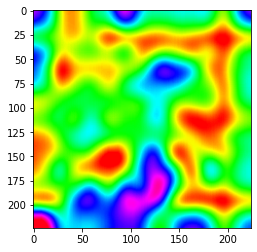

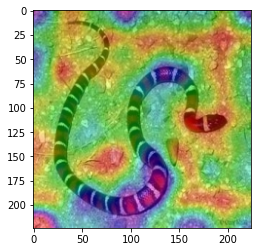

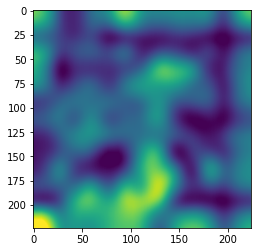

Grad cam completed


In [16]:
# Get params
target_example = 0  # Snake
(original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
    get_example_params(target_example)
# Grad cam
grad_cam = GradCam(pretrained_model, target_layer=11)
# Generate cam mask
cam = grad_cam.generate_cam(prep_img, target_class)
# Save mask
save_class_activation_images(original_image, cam, file_name_to_export)
print('Grad cam completed')

In [1]:
list = 3 * [0] + 4 * [1]
list

[0, 0, 0, 1, 1, 1, 1]